In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

plt.style.use('Solarize_Light2')

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Golden Rule: make series stationary before analysis. If the mean of a time-series increases over time, then it's not stationary.

Transforms used for stationarizing data:
##### De-trending : 

We remove the underlying trend in the series. This can be done in several ways, depending on the nature of data :
- Indexed data: data measured in currencies are linked to a price index or related to inflation. Dividing the series by this index (ie deflating) element-wise is therefore the solution to de-trend the data.

- Non-indexed data: is it necessary to estimate if the trend is constant, linear or exponential. The first two cases are easy, for the last one it is necessary to estimate a growth rate (inflation or deflation) and apply the same method as for indexed data.

- Differencing : Seasonal or cyclical patterns can be removed by substracting periodical values. If the data is 12-month seasonal, substracting the series with a 12-lag difference series will give a “flatter” series

- Logging : in the case where the compound rate in the trend is not due to a price index (ie the series is not measured in a currency), logging can help linearize a series with an exponential trend (recall that log(exp(x)) = x). It does not remove an eventual trend whatsoever, unlike deflation.

Plotting rolling means and variances is a first good way to visually inspect our series. If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then you might conclude that the series is very likely not to be stationary.

### These methods serve as benchmark to ensure that the new method is better than the follwing


#### average forecasting $$\hat{y}_{T+h | T} = \sum_{i=1}^T (y_i)/T$$

#### Naive method is to use the last possible value: $$\hat{y}_{T+h | T } = y_T$$
- seasonal naive: $$\hat{y}_{T+h | T} = y_{T+h - m(k+1)},$$
where $m$ is the seasonal period and and $k$ is the integer part of $(h - 1)/m$
(i.e., the number of complete years in the forecast period prior to time T + h) 

#### Drift method: $$\hat{y}_{T+h | T} = y_T + \frac{h}{T-1}\sum_{t=2}^T (y_t - y_{t-1})$$
This is equivalent to drawing a line between the first and last observations, and extrapolating it into the future

#### Hystorical data adjustments tricks
- Calendar radjustments:
    - By looking at the average daily production instead of the total monthly production, we effectively remove the variation due to the different month lengths.

#### Box-Cox transformations: 
$$w_t=\begin{equation}
\left\{ 
  \begin{aligned}
    \log(y_t)\,&&\text{if} \lambda = 0;\\
    (y_t^{\lambda} - 1) / \lambda \, && \text{otherwise}\\
  \end{aligned}
  \right.
\end{equation}
$$
A good value of $\lambda$ is one which makes the size of the seasonal variation about the same across the whole series.

One issue with using mathematical transformations such as Box-Cox transformations is that the back-transformed point forecast will not be the mean of the forecast distribution. In fact, it will usually be the median of the forecast distribution (assuming that the distribution on the transformed space is symmetric). 

Bias-adjustmen:
$$
y_t=\begin{equation}
\left\{ 
  \begin{aligned}
    \exp(w_t)\big[1+\frac{\sigma_h^2}{2}\big]\,&&\text{if} \lambda = 0;\\
    (\lambda w_t + 1)^{1/\lambda}\big[1 + \frac{\sigma_h^2(1-\lambda)}{2(\lambda w_t + 1)^2}\big] \, && \text{otherwise}\\
  \end{aligned}
  \right.
\end{equation}
$$
where $\sigma_h^2$ is the variance at the $h$ step

In [2]:
wine['sales_box'], lmbda = stats.boxcox(wine.sales)

NameError: name 'stats' is not defined

$$e_t = y_t - \hat{y}_t$$

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:
- The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
- The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.
- The residuals have constant variance.
- The residuals are normally distributed.

#### Portmanteau tests for autocorrelation
Whether the first $h$ autocorrelations are significantly different from what would be expected from a white noise process. A test for a group of autocorrelations is called a portmanteau test:
- Box-Pierce test: $$Q = T \sum_{k=1}^l r_k^2,$$
where $l$ is the maximum lag being considered and $T$ is the number of observations; $l=10$ for non-seasonal data, $l=2m,$ where $m$ is season period for seasonal data and $l <= T/5$

- Ljung-Box test: $Q^* = T(T+2) \sum_{k=1}^l (T-k)^{-1} r_k^2$

Large values of $Q$ suggest that the autocorrelations do not come from a white noise series.

A forecast “error” is the difference between an observed value and its forecast.
$$e_{T+h} = y_{T+h} - \hat{y}_{T+h | T} $$
- $\text{MAE} = \text{mean}(|e_t|)$
- $\text{RMSE} = \sqrt{\text{mean}(e_t^2)}$

First, residuals are calculated on the training set while forecast errors are calculated on the test set. Second, residuals are based on one-step forecasts while forecast errors can involve multi-step forecasts.

When comparing forecast methods applied to a single time series, or to several time series with the same units, the MAE is popular as it is easy to both understand and compute. A forecast method that minimises the MAE will lead to forecasts of the median, while minimising the RMSE will lead to forecasts of the mean. Consequently, the RMSE is also widely used, despite being more difficult to interpret.

Percentage error: $$p_t = 100e_t/y_t$$
MAPE: $\text{mean}(|p_t|)$
MAPE puts a heavier penalty on negative errors than on positive errors.
sMAPE: $\text{mean}(200|y_t - \hat{y}_t|/(y_t + \hat{y}_t))$


Prediction interval is: $$\hat{y}_{T+h | T} \pm c \hat{\sigma}_h, $$ lookup $c$ from the table for a proper percentage range.
TODO: Дополни тем что ты нашел при подготовке к JetBrains

#### Forecasts for the standard deviation for the benchmark methods:
- Mean: $\hat{\sigma}_h = \sigma \sqrt{1 + 1/T}$
- Naive: $\hat{\sigma}_h = \sigma \sqrt{h}$
- Seasonal naive: $\hat{\sigma}_h = \sigma \sqrt{k+1}, $ where $k=\text{INT}((h-1)/m),$ $m$ is the seasonal period
- Drift forecast: $\hat{\sigma}_h = \hat{sigma} \sqrt{h(1+h/T)}$

#### Prediction using the bootstrapped residuals
$$y_t = \hat{y}_{t | t+1} + e_t$$
For the next steps we can sample the residuals from it's distribution and obtain: 
$$y_{T+i} = \hat{y}_{T+i|T+i-1} + e_{T+i}$$
where $e_{T+i}$ is sampled from the distribution of $\text{distr}(e_{T+i-1})$

When there are not so much of a data, one can use judgmental forecasting. However, it requires a systematic approach, since the judgment is biased by an opinion, emotions, human factor in general.
TODO: read the 4th chapter: https://otexts.com/fpp2/regression.html

### Exponential smoothing

#### Reasoning: it may be sensible to attach larger weights to more recent observations than to observations from the distant past.

This is exactly the concept behind simple exponential smoothing. Forecasts are calculated using weighted averages, where the weights decrease exponentially as observations come from further in the past — the smallest weights are associated with the oldest observations:
$$\hat{y}_{T+1|T} = \alpha y_T + \alpha (1-\alpha)y_{T-1} + \alpha(1-\alpha^2) y_{T-2} + ...,$$
where $0 <= \alpha <= 1$ is the smoothing parameter. General formula would look like:
$$\hat{y}_{T+1|T} = \sum_{j=0}^{T-1} \alpha (1-\alpha)^j y_{T-j} + (1 - \alpha)^T l_0$$
Thus we can separate into:
- forecast equation: $\hat{y}_{t+h|t} = l_t$
- smoothing equation: $l_t = \alpha y_t + (1- \alpha)l_{t-1}$

For the time series with no trend or seasonal component, one can use:
$\hat{y}_{T+h|T} = \hat{y}_{T+1|T} = l_T$

In [10]:
def simple_exponential_smoothing(series, alpha):
    results = np.zeros_like(series)
    
    results[0] = series[0]
    for t in range(1, series.shape[0]):
        results[t] = alpha * series[t] + (1 - alpha)*series[t-1]
        
    return results

In [12]:
def plot_exponential_smoothing(series, alphas):
    """Plots exponential smoothing with different alphas."""  
    plt.figure(figsize=(15, 7))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))

    plt.plot(series, label='Actual')
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title('Exponential Smoothing')
    plt.grid(True)

#### Holt's linear trend method

The basic idea is saying if our time series has a trend, we can incorporate that information to do better than just estimating the current level and using that to forecast the future observations. To achieve this, we will introduce two new notations: the current "trend", denoted by  𝑇  (we can think of it as the slope of the time series), as well as the current "level", denoted by  ℓ .

- Forecast equation: $\hat{y}_{t+h|t} = l_t + h b_t$
- Level equation: $l_t = \alpha y_t + (1 - \alpha)(l_{t-1} + b_{t-1})$
- Trend equation: $b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*)b_{t-1},$ Usually the trend is constant here that leads to over-forecasting for a long horizon it can be fixed by dumping
where $0 <= \beta^* <= 1$ is the smoothing parameter for the trend

ℓ , level is simply predicted point. But because now it's going to be only part of calculation of the forecast (our forecast is a combination of predicted point and trend), we can no longer refer to it as  𝑦̂  
The second equation introduces  0<𝛽<1 , the trend coefficient. As with  𝛼 , some values of  𝛽  work better than others depending on the series. When  𝛽  is big, we won't give too much weight to the past trends when estimating current trend
Similar to exponential smoothing, where we used the first observed value as the first expected value, we can use the first observed trend as the first expected trend, i.e. we'll use the first two points to compute the initial trend, i.e.  (𝑦𝑥−𝑦𝑥−1)/1 .


#### Dumped trend methods
- Forecast equation: $\hat{y}_{t+h|t} = l_t + (\phi + \phi^2 + ... + \phi^h) b_t$
- Level equation: $l_t = \alpha (y_t - s_{t-m}) + (1 - \alpha)(l_{t-1} + b_{t-1})$
- Trend equation: $b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*) b_{t-1},$
where $0<= \phi <= 1$ is a dumping parameter, in practise $0.8 <= \phi < 1$

In [ ]:
def Holts_linear_trend_method(series, alpha, beta, n_preds=2):
    """
    Given a series, alpha, beta and n_preds (number of
    forecast/prediction steps), perform the prediction.
    """
    
    n_record = series.shape[0]
    results = np.zeros(n_record + n_preds)
    
    # first value remains the same as series,
    # as there is no history to learn from;
    # and the initial trend is the slope/difference
    # between the first two value of the series
    
    level = series[0]
    results[0] = series[0]
    trend = series[1] - series[0]
    
    for t in range(1, n_record + 1):
        if t >= n_record:
            # forecasting new points
            value = results[t-1]
        else:
            value = series[t]
            
        previous_level = level
        level = alpha * value + (1 - alpha)*(level + trend)
        trend = beta * (level - previous_level) + (1 - beta)*trend
        results[t] = level + trend
    
    if n_preds > 1:
        results[n_record + 1:] = level + np.arange(2, n_preds + 1)*trend
    return results

In [ ]:
def holts(series, alpha, beta, n_preds=2):
    n_records = series.shape[0]
    
    results = np.zeros(n_records + n_preds)
    results[0] = series[0]
    level = series[0]
    trend = series[1] - series[0]
    
    for t in range(1, n_records + 1):
        if t > n_records:
            value = results[t-1]
        else:
            value = series[t]
            
        previous_level = level
        level = alpha*value + (1 - alpha)*(level + trend)
        trend = beta*(level-previous_level) + (1-beta)*trend
        results[t] = level + trend
        
    if n_preds > 1:
        results[n_records + 1:] = level + np.arange(2, n_preds + 1)*trend
    return results

#### Holt-Winters seasonal methods
Additive (seasonal variations are roughly constant through the series):
- Forecast equation: $\hat{y}_{t+h|t} = l_t + h b_t + s_{t + h - m (k+1)}$
- Level equation: $l_t = \alpha y_t + (1 - \alpha)(l_{t-1} +  b_{t-1})$
- Trend equation: $b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*) b_{t-1},$
- Seasonal equation: s_t = $\gamma(y_t - l_{t-1} - b_{t-1}) + (1 - \gamma)s_{t-m}$

where $k = \text{INT}((h-1)/m)$ is a dumping parameter, in practise $0.8 <= \phi < 1$

Multiplicative (seasonal variations are changing proportional to the level of the series)
- Forecast equation: $\hat{y}_{t+h|t} = (l_t + h b_t)s_{t + h - m (k+1)}$
- Level equation: $l_t = \alpha y_t/s_{t-m} + (1 - \alpha)(l_{t-1} + b_{t-1})$
- Trend equation: $b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*) b_{t-1},$
- Seasonal equation: s_t = $\gamma y_t/ (l_{t-1} + b_{t-1}) + (1 - \gamma)s_{t-m}$

#### Holt-Winters seasonal damped method
- Forecast equation: $\hat{y}_{t+h|t} = [l_t + (\phi + \phi^2 + ... + \phi^h) b_t] s_{t + h - m (k+1)}$
- Level equation: $l_t = \alpha y_t/s_{t-m} + (1 - \alpha)(l_{t-1} + \phi b_{t-1})$
- Trend equation: $b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*) \phi b_{t-1},$
- Seasonal equation: s_t = $\gamma y_t/ (l_{t-1} + \phi b_{t-1}) + (1 - \gamma)s_{t-m}$

In [13]:
def initial_trend(series, season_len):
    total = 0.0
    for i in range(season_len):
        total += (series[i+season_len] - series[i]) / season_len
    
    trend = total / season_len
    return trend

In [14]:
def return_season_averages(series, season_len):
    n_seasons = len(series) // season_len

    season_averages = np.zeros(n_seasons)

    for j in range(n_seasons):
        start_index = season_len * j
        end_index = start_index + season_len
        season_average = np.sum(series[start_index:end_index]) / season_len
        season_averages[j] = season_average

    return season_averages

In [ ]:
# estimate the initial seasonal components
n_seasons = len(series) // season_len
seasonals = np.zeros(season_len)
seasons = np.arange(n_seasons)
index = seasons * season_len
for i in range(season_len):
    seasonal = np.sum(series[index + i] - season_averages) / n_seasons
    seasonals[i] = seasonal

In [17]:
np.arange(10) * 5

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])

In [18]:
class HoltWinters:
    """Scikit-learn like interface for Holt-Winters method."""

    def __init__(self, season_len=24, alpha=0.5, beta=0.5, gamma=0.5):
        self.beta = beta
        self.alpha = alpha
        self.gamma = gamma
        self.season_len = season_len

    def fit(self, series):
        # note that unlike scikit-learn's fit method, it doesn't learn
        # the optimal model paramters, alpha, beta, gamma instead it takes
        # whatever the value the user specified the produces the predicted time
        # series, this of course can be changed.
        beta = self.beta
        alpha = self.alpha
        gamma = self.gamma
        season_len = self.season_len
        seasonals = self._initial_seasonal(series)

        # initial values
        predictions = []
        smooth = series[0]
        trend = self._initial_trend(series)
        predictions.append(smooth)

        for i in range(1, len(series)):
            value = series[i]
            previous_smooth = smooth
            seasonal = seasonals[i % season_len]
            smooth = alpha * (value - seasonal) + (1 - alpha) * (previous_smooth + trend)
            trend = beta * (smooth - previous_smooth) + (1 - beta) * trend
            seasonals[i % season_len] = gamma * (value - smooth) + (1 - gamma) * seasonal
            predictions.append(smooth + trend + seasonals[i % season_len])

        self.trend_ = trend
        self.smooth_ = smooth
        self.seasonals_ = seasonals
        self.predictions_ = predictions
        return self
    
    def _initial_trend(self, series):
        season_len = self.season_len
        total = 0.0
        for i in range(season_len):
            total += (series[i + season_len] - series[i]) / season_len

        trend = total / season_len
        return trend

    def _initial_seasonal(self, series):
        season_len = self.season_len
        n_seasons = len(series) // season_len

        season_averages = np.zeros(n_seasons)
        for j in range(n_seasons):
            start_index = season_len * j
            end_index = start_index + season_len
            season_average = np.sum(series[start_index:end_index]) / season_len
            season_averages[j] = season_average

        seasonals = np.zeros(season_len)
        seasons = np.arange(n_seasons)
        index = seasons * season_len
        for i in range(season_len):
            seasonal = np.sum(series[index + i] - season_averages) / n_seasons
            seasonals[i] = seasonal

        return seasonals

    def predict(self, n_preds=10):
        """
        Parameters
        ----------
        n_preds: int, default 10
            Predictions horizon. e.g. If the original input time series to the .fit
            method has a length of 50, then specifying n_preds = 10, will generate
            predictions for the next 10 steps. Resulting in a prediction length of 60.
        """
        predictions = self.predictions_
        original_series_len = len(predictions)
        for i in range(original_series_len, original_series_len + n_preds):
            m = i - original_series_len + 1
            prediction = self.smooth_ + m * self.trend_ + self.seasonals_[i % self.season_len]
            predictions.append(prediction)

        return predictions

In [19]:
# learning params
def timeseries_cv_score(params, series, loss_function, season_len=24, n_splits=3):
    """
    Iterating over folds, train model on each fold's training set,
    forecast and calculate error on each fold's test set.
    """
    errors = []    
    alpha, beta, gamma = params
    time_series_split = TimeSeriesSplit(n_splits=n_splits) 

    for train, test in time_series_split.split(series):
        model = HoltWinters(season_len, alpha, beta, gamma)
        model.fit(series[train])

        # evaluate the prediction on the test set only
        predictions = model.predict(n_preds=len(test))
        test_predictions = predictions[-len(test):]
        test_actual = series[test]
        error = loss_function(test_actual, test_predictions)
        errors.append(error)

    return np.mean(errors)


In [20]:
# provide initial values for model parameters' alpha, beta and gamma
# and leave out the last 20 points of our time series as test set
x = [0, 0, 0]
test_size = 20
data = series.values[:-test_size]
opt = minimize(timeseries_cv_score, x0=x, 
               args=(data, mean_squared_log_error), 
               method='TNC', bounds=((0, 1), (0, 1), (0, 1)))

print('original parameters: {}'.format(str(x)))
print('best parameters: {}'.format(str(opt.x)))

# retrieve optimal values, train the finnal model with them
# and generating forecast for next 50 hours
alpha_final, beta_final, gamma_final = opt.x
model = HoltWinters(season_len, alpha_final, beta_final, gamma_final)
model.fit(data)
predictions = model.predict(n_preds=50)

print('original series length: ', len(series))
print('prediction length: ', len(predictions))

# more on this evaluation metric in the section below
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


data = series.values
error = mean_absolute_percentage_error(data, predictions[:len(series)])

plt.figure(figsize=(20, 10))
plt.plot(predictions, label='Prediction')
plt.plot(data, label='Actual')
plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
plt.axvspan(len(series) - test_size, len(predictions), alpha=0.3, color='lightgrey')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='best', fontsize=13)
plt.show()

NameError: name 'series' is not defined

#### Итоговый алгоритм подбора модели в классе ARIMA состоит в следующем:

• В первую очередь необходимо построить график ряда и посмотреть на него. Уже из визуального анализа можно сделать определённые выводы: есть ли в данных сезонность, какой сезонный период, есть
ли в ряде пропуски и выбросы, необходимо ли стабилизировать дисперсию, стоит ли исключить из
рассмотрения начало ряда, потому что значения в начале совсем не похожи на значения в конце.

• Следующий шаг — это стабилизация дисперсии при необходимости. Стабилизация производится с помощью метода Бокса-Кокса или логарифмированием, что является частным случаем того же метода.

• Если исследуемый ряд нестационарен, необходимо подобрать порядок дифференцирования, при котором
он становится стационарным. Таким образом фиксируются параметры d, D модели ARIMA.

• Далее необходимо построить графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF) и из этих графиков определить примерные значения параметров p, q, P, Q.
Фактически эти значения — начальные приближения, с которых начинается перебор разных моделей.

• Полученные модели необходимо обучить, сравнить их по информационному критерию Акаике и выбрать
ту, которая его минимизирует.

• Необходимо посмотреть на остатки получившейся модели, чтобы понять, насколько хорошей она получилась, можно ли, теоретически, её улучшить, нет ли в ней каких-то видимых недостатков. Подробнее
об анализе остатков будет рассказано позднее.

ADF vs KPSS test:

- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

$\text{AIC} = 2k - 2\log(L)$ - критерий Акакике для выбора модели, чем меньше значение -> тем лучше

In [ ]:
# Example

In [21]:
class Holt:
    def __init__(self, alpha=0.5, beta=0.5):
        self.alpha = alpha
        self.beta = beta
        
    def fit_predict(self, series, n_preds=2):
        alpha = self.alpha
        beta = self.beta
        
        n_record = series.shape[0]
        results = np.zeros(n_record + n_preds)
        
        level = series[0]
        results[0] = series[0]
        trend = series[1] - series[0]
        for t in range(1, n_record + 1):
            if t >= n_record:
                value = results[t-1]
            else: 
                value = series[t]
            
            previous_level = level
            level = alpha*value + (1 - alpha)*(level + trend)
            trend = beta*(level - previous_level) + (1-beta)*trend
            results[t] = level + trend
            
        if n_preds > 1:
            results[n_record+1:] = level + np.arange(2, n_preds + 1)*trend
            
        return results

In [22]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

In [23]:
def timeseries_cv_score(params, series, loss_function, n_splits=3):
    errors = []
    alpha, beta = params
    time_series_split = TimeSeriesSplit(n_splits=n_splits)
    
    for train, test in time_series_split.split(series):
        model = Holt(alpha, beta)
        predictions = model.fit_and_pred(series[train])
        
        test_predictions = predictions[-len(test):]
        actual_test = series[test]
        error = loss_function(actual_test, test_predictions)
        errors.append(error)
    return np.mean(errors)

In [24]:
x = [0, 0]
test_size = 20
data = series.values[:-test_size]
opt = minimize(timeseries_cv_score, x0=x, args=(data, mean_squared_log_error),
              method='TNC', bounds=((0,1), (0,1)))

print('original parameters: {}'.format(str(x)))
print('best parameters: {}'.format(str(opt.x)))

NameError: name 'series' is not defined

In [ ]:
def plot_double_exponential_smoothing(series, alphas, betas):
    """Plots double exponential smoothing with different alphas and betas."""    
    plt.figure(figsize=(20, 8))
    for alpha, beta in zip(alphas, betas):
        results = double_exponential_smoothing(series, alpha, beta)
        plt.plot(results, label='Alpha {}, beta {}'.format(alpha, beta))

    plt.plot(series, label='Actual')
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title('Double Exponential Smoothing')
    plt.grid(True)

plot_double_exponential_smoothing(series.values, alphas=[0.9, 0.9], betas=[0.1, 0.9])

### Example

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
from scipy import stats

%matplotlib inline
%pylab inline
plt.style.use('Solarize_Light2')

Populating the interactive namespace from numpy and matplotlib


In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [8]:
data = pd.read_csv('Datamarket/datasets-master/monthly-milk-production-pounds.csv', 
                 index_col=['Month'], parse_dates=['Month'])
df = data.rename(columns={'Monthly milk production (pounds per cow)': 'data'})
df.head()

,data
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


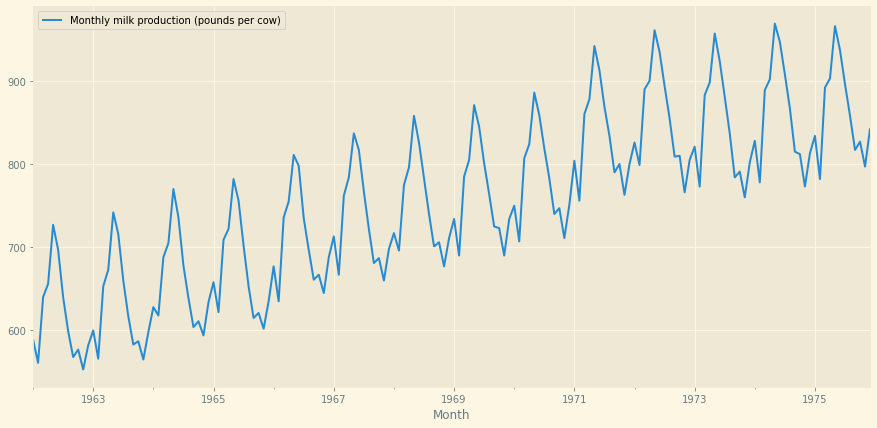

In [6]:
df.plot(figsize=(15,7))

In [10]:
TEST_SIZE = 24
train, test = df.iloc[:-TEST_SIZE, :], df.iloc[-TEST_SIZE:, :]
train.index, test.index = pd.to_datetime(train.index), pd.to_datetime(test.index)
pred = test.copy()

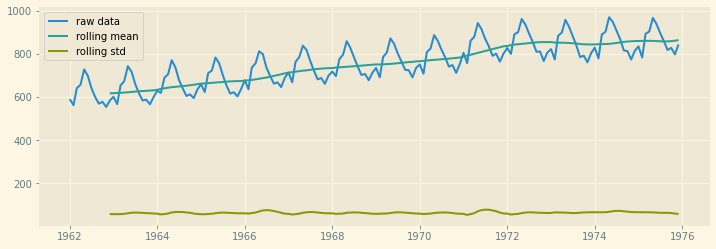

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df.data, label='raw data')
plt.plot(df.index, df.data.rolling(window=12).mean(), label='rolling mean', color='red')
plt.plot(df.index, df.data.rolling(window=12).std(), label='rolling std', color='orange')
plt.legend()
plt.show()

p-value = 0.627426708603034


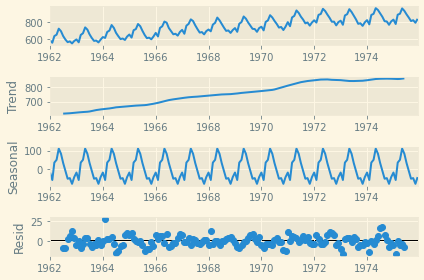

In [14]:
#plt.figure(figsize=(12,3))

decompose = seasonal_decompose(df)
decompose.plot()
print('p-value = ' + str(adfuller(df.data)[1]))

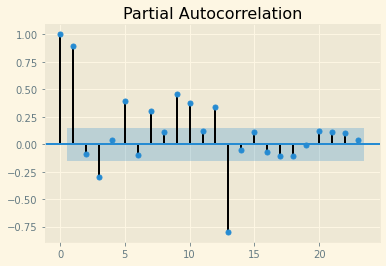

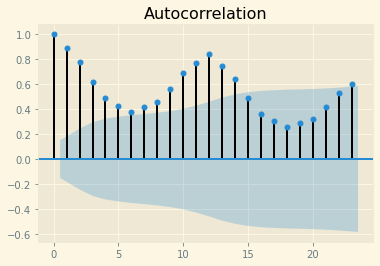

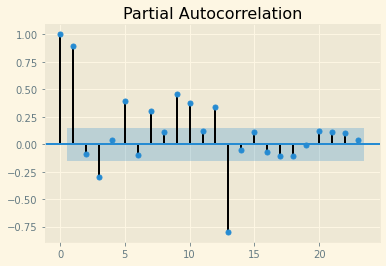

In [16]:
plot_acf(df)
plot_pacf(df)

In [17]:
# simple exponenetial smoothing
def simple_exp_smoothing(data, alpha=0.8):
    exp_smoothing = [data[0]]
    for i in range(1, len(data)):
        exp_smoothing.append(alpha*data[i] + (1 - alpha)*data[i-1])
    return exp_smoothing

df['simple_exp_smoothing'] = simple_exp_smoothing(df.data, alpha=0.85)

# shift the smoothing by one element further
from datetime import timedelta

last_date = df.iloc[[-1]].index
last_date += timedelta(days = 1)
last_date

df = df.append(pd.DataFrame(index=last_date))
df.simple_exp_smoothing = df.simple_exp_smoothing.shift(1)

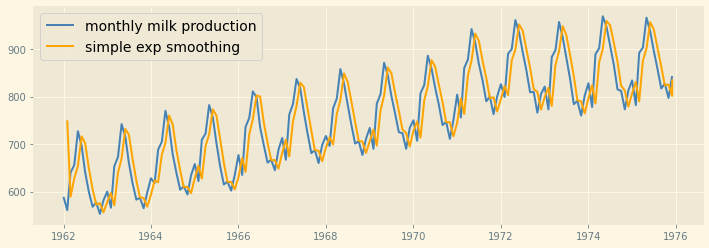

In [18]:
# plot simple smoothing
plt.figure(figsize=(12,4))

plt.plot(df.data, label='monthly milk production', color='steelblue')
plt.plot(df.simple_exp_smoothing, label='simple exp smoothing', color='orange')

plt.legend(title='', loc='upper left', fontsize=14)

plt.show()

In [19]:
# we have some trend and no deviation in std, so no need in boxcox transformation, but better to de-trend
df['z_data'] = (df.data - df.data.rolling(window=12).mean()) / df.data.rolling(window=12).std()
df['zp_data'] = df.z_data - df.z_data.shift(12)

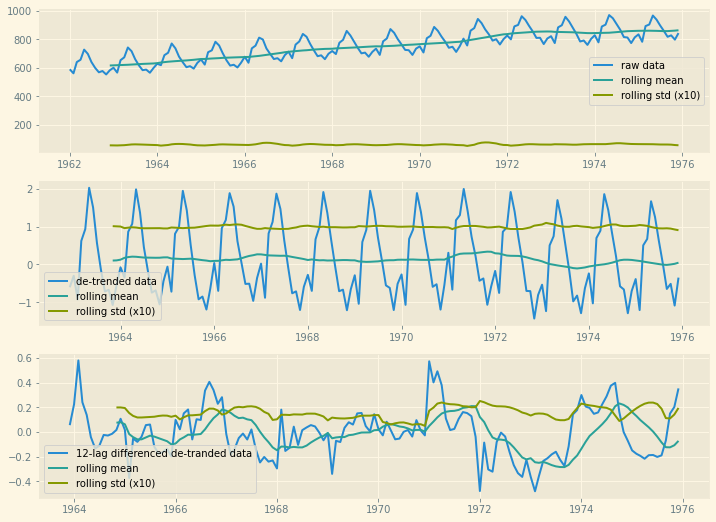

In [20]:
fig, ax = plt.subplots(3, figsize=(12, 9))

ax[0].plot(df.index, df.data, label='raw data')
ax[0].plot(df.data.rolling(window=12).mean(), label='rolling mean')
ax[0].plot(df.data.rolling(window=12).std(), label='rolling std (x10)')
ax[0].legend()

ax[1].plot(df.index, df.z_data, label='de-trended data')
ax[1].plot(df.z_data.rolling(window=12).mean(), label='rolling mean')
ax[1].plot(df.z_data.rolling(window=12).std(), label='rolling std (x10)')
ax[1].legend()

ax[2].plot(df.index, df.zp_data, label='12-lag differenced de-tranded data')
ax[2].plot(df.zp_data.rolling(window=12).mean(), label='rolling mean')
ax[2].plot(df.zp_data.rolling(window=12).std(), label='rolling std (x10)')
ax[2].legend()

In [21]:
def if_data_staionary_dfuller(df, clmn_name):
    print(f" > Is the data {clmn_name} stationary ?")
    dftest = adfuller(df[clmn_name].dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, 
                                                                                "not" if v<dftest[0] else "", 
                                                                                100-int(k[:-1])))
    print()

In [22]:
def if_data_stationary_kpss(df, clmn_name):
    from statsmodels.tsa.stattools import kpss
    print("Results of KPSS Test:")
    kpsstest = kpss(df[clmn_name].dropna(), regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [23]:
if_data_staionary_dfuller(df, 'data')
if_data_staionary_dfuller(df, 'z_data')
if_data_staionary_dfuller(df, 'zp_data')

 > Is the data data stationary ?
Test statistic = -1.304
P-value = 0.627
Critical values :
	1%: -3.473542528196209 - The data is not stationary with 99% confidence
	5%: -2.880497674144038 - The data is not stationary with 95% confidence
	10%: -2.576878053634677 - The data is not stationary with 90% confidence

 > Is the data z_data stationary ?
Test statistic = -2.905
P-value = 0.045
Critical values :
	1%: -3.4769274060112707 - The data is not stationary with 99% confidence
	5%: -2.8819726324025625 - The data is  stationary with 95% confidence
	10%: -2.577665408088415 - The data is  stationary with 90% confidence

 > Is the data zp_data stationary ?
Test statistic = -3.154
P-value = 0.023
Critical values :
	1%: -3.4808880719210005 - The data is not stationary with 99% confidence
	5%: -2.8836966192225284 - The data is  stationary with 95% confidence
	10%: -2.5785857598714417 - The data is  stationary with 90% confidence



In [24]:
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)

/Users/aleksandrglushko/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/aleksandrglushko/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [29]:
fit = model.fit(smoothing_level=0.7)
pred = fit.forecast(24)
sse = np.sqrt(np.mean(np.square(test.values - pred.values)))

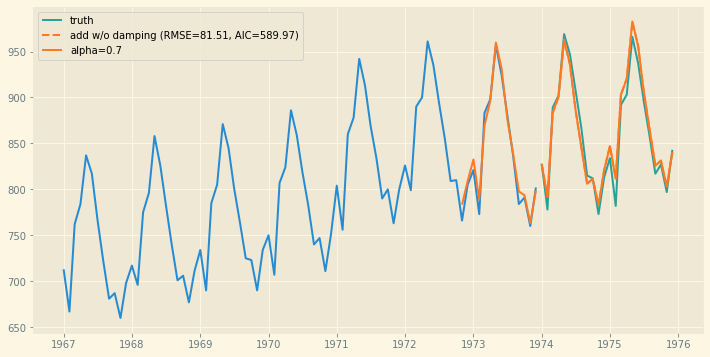

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train.index[60:], train.data[60:])
ax.plot(test.index, test.values, label='truth')
ax.plot(test.index, pred, linestyle='--', color='#ff7823', 
        label="add w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse, fit.aic))
# ax.plot(test.index, pred1, linestyle='--', color='#3c763d', 
#         label="add w damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit1.aic))
# ax.plot(test.index, pred2, linestyle='--', color='#eeaa77', 
#         label="mul w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic))
c = '#ff7823'

ax.plot(train.index[130:], fit.fittedvalues[130:], color=c)
ax.plot(test.index, pred, label="alpha="+str(fit.params['smoothing_level'])[:4], color=c)

ax.legend()